# This jupyter notebook provides various analysis about shear results

In [21]:
%aiida
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## imports and settings

In [78]:
import os
import yaml
import numpy as np
from pprint import pprint
from matplotlib import pyplot as plt
from copy import deepcopy
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from aiidaplus.plot import (line_chart,
                            band_plot,
                            bands_plot,
                            get_plot_properties_from_trajectory)
from aiidaplus.get_data import get_structure_data, get_relax_data, get_phonon_data
from aiidaplus.utils import (get_qpoints_from_band_labels,
                             get_default_labels_of_twinmode)
from twinpy.lattice.brillouin import get_labels_for_twin
import seekpath

shear_dir = os.path.join('..', 'data', 'shear')

## extract yaml files

In [23]:
yamlfiles = [ name for name in os.listdir(shear_dir) if 'yaml' in name ]
yamlfiles.sort()
shears = []
for yamlfile in yamlfiles:
    with open(os.path.join(shear_dir, yamlfile)) as f:
        shears.append(yaml.load(f, Loader=yaml.SafeLoader))

## data details

In [24]:
print("# keys of each shear data")
print(shears[0].keys())
print("")
for key in shears[0].keys():
    print("# "+key)
    pprint(shears[0][key])
    print("")

# keys of each shear data
dict_keys(['calculator_settings', 'gamma', 'parent', 'phonon_pks', 'pk', 'relax_pks', 'relax_results', 'shear_conf', 'shear_ratios'])

# calculator_settings
{'phonon': {'incar_settings': {'addgrid': True,
                               'ediff': 1e-08,
                               'encut': 300,
                               'gga': 'PS',
                               'ialgo': 38,
                               'ismear': 0,
                               'lcharg': False,
                               'lreal': False,
                               'lwave': False,
                               'npar': 4,
                               'prec': 'Accurate',
                               'sigma': 0.4},
            'kpoints': {'mesh': [5, 5, 4], 'offset': [0, 0, 0.5]},
            'options': {'max_wallclock_seconds': 360000,
                        'queue_name': 'vega-a'},
            'phonon_conf': {'distance': 0.03,
                            'mesh': [18, 18, 

## energies

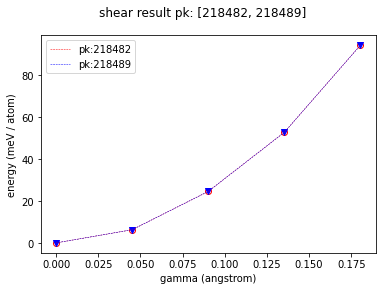

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)
pks = []
for shear in shears:
    pks.append(shear['pk'])
    line_chart(
            ax,
            shear['gamma'] * np.array(shear['shear_ratios']),
            (np.array(shear['relax_results']['energies']) \
                - shear['relax_results']['energies'][0]) \
                  * 1000 / shear['parent']['natoms'],
            "gamma (angstrom)",
            "energy (meV / atom)",
            label = 'pk:' + str(shear['pk'])
            )
ax.legend()
fig.suptitle('shear result pk: %s' % pks)
plt.show()

In [41]:
# def get_labels_from_phonon(phonon):
#     cell = phonon.get_unitcell().cell
#     positions = phonon.get_unitcell().scaled_positions
#     numbers = phonon.get_unitcell().get_atomic_numbers().tolist()
#     structure = (cell, positions, numbers)
#     return get_labels_for_twin(structure)

# Single band strcuture

In [58]:
labels = get_default_labels_of_twinmode(shears[0]['shear_conf']['twinmode'])
pmgstructure = load_node(shears[0]['parent']['pk']).get_pymatgen_structure()
qpoints = get_qpoints_from_band_labels(pmgstructure, labels)

shear_phonons = []
for shear in shears:
    phonons = []
    for pk in shear['phonon_pks']:
        try:
            _, phonon = get_phonon_data(pk, get_phonon=True)
        except:
            print("phonon calc seems to have failed pk:{}".format(pk))
        phonons.append(phonon)
    shear_phonons.append(phonons)

### auto

# band path is set automalically


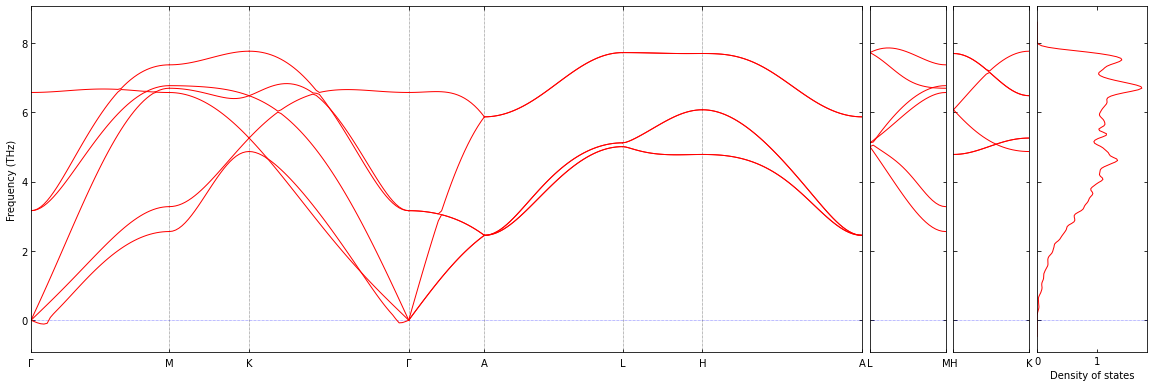

In [59]:
fig = plt.figure(figsize=(20,9))
band_plot(fig=fig,
          phonon=shear_phonons[0][0],
          is_auto=True,
          with_dos=True,
          mesh=[18,18,10])

### manually

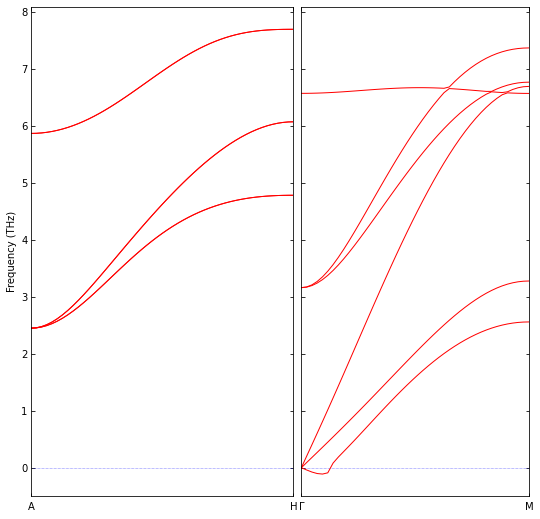

In [60]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'GAMMA', 'M']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2]],
                            [[0,0,0],
                             [1/2,0,0]]])
band_plot(fig=fig,
          phonon=shear_phonons[0][0],
          band_labels=band_labels,
          segment_qpoints=segment_qpoints,
          is_auto=False)

# comparing with two or more different band structures

## auto

# band path is set automalically


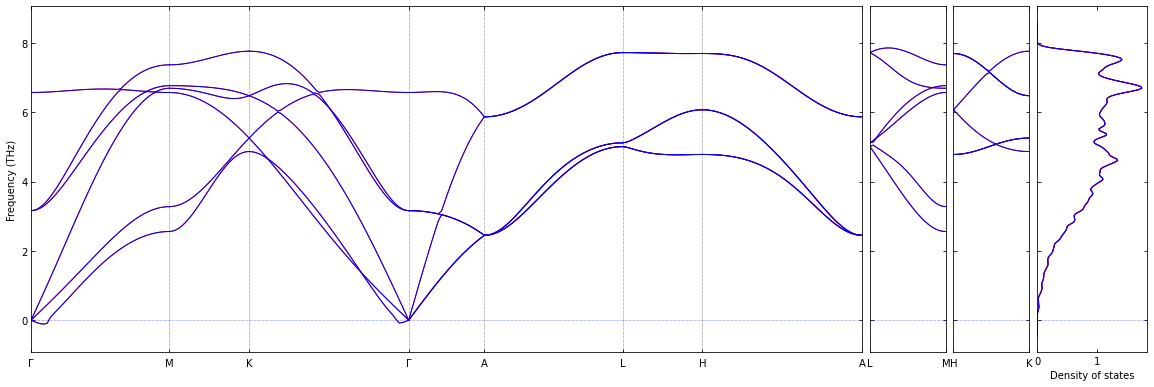

In [61]:
fig = plt.figure(figsize=(20,9))
bands_plot(fig=fig,
           phonons=[shear_phonons[0][0], shear_phonons[1][0]],
           with_dos=True,
           mesh=[18,18,10],
           is_auto=True)

### manually

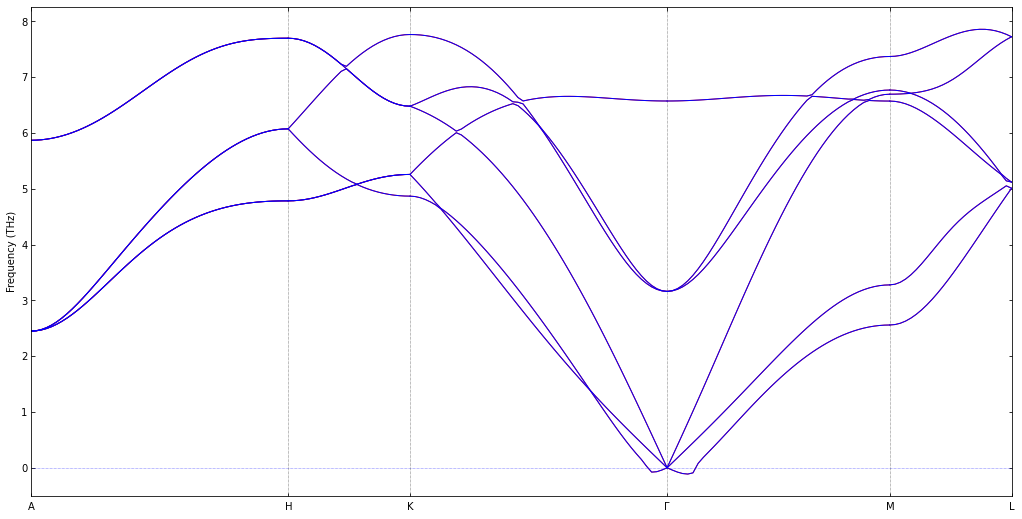

In [62]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'K', 'GAMMA', 'M', 'L']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2],
                             [1/3,1/3,0],
                             [0,0,0],
                             [1/2,0,0],
                             [1/2,0,1/2]]])

bands_plot(fig=fig,
           phonons=[shear_phonons[0][0], shear_phonons[1][0]],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           is_auto=False)

# compare shear structures

Some points are sharp which is strange because 'A', for example, is originally BZ boundary but after shearing, it's not any more.

## auto

## TODO
Crystal rotation from primitive for calc to priimitive original may be broken because of updating code.

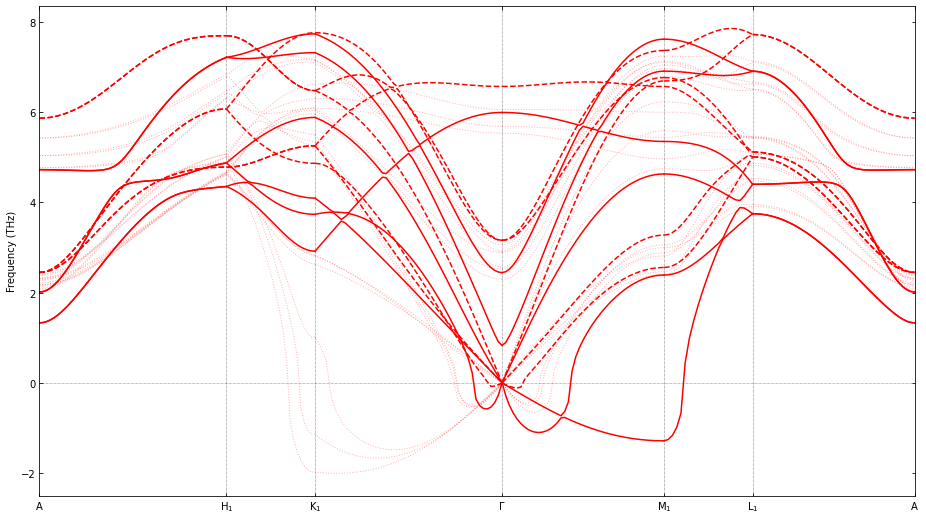

In [84]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H_1', 'K_1', 'GAMMA', 'M_1', 'L_1', 'A']
all_labels = get_labels_for_twin()
segment_qpoints = np.array([[ all_labels[label] for label in band_labels ]])
cs, alphas, linewidths, linestyles = \
    get_plot_properties_from_trajectory(plot_nums=len(shear_phonons[0]),
                                        base_color='r')
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           cs=cs,
           alphas=alphas,
           linewidths=linewidths,
           linestyles=linestyles,
           xscale=18,
           is_auto=False)

## manually

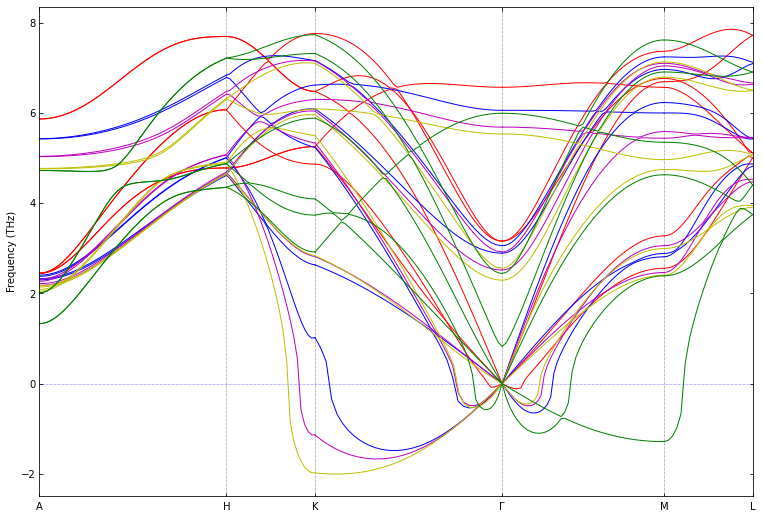

In [86]:
fig = plt.figure(figsize=(20,9))
band_labels = ['A', 'H', 'K', 'GAMMA', 'M', 'L']
segment_qpoints = np.array([[[0,0,1/2],
                             [1/3,1/3,1/2],
                             [1/3,1/3,0],
                             [0,0,0],
                             [1/2,0,0],
                             [1/2,0,1/2]]])
bands_plot(fig=fig,
           phonons=shear_phonons[0],
           band_labels=band_labels,
           segment_qpoints=segment_qpoints,
           xscale=18,
           is_auto=False)